 **Getting Started - siamxt**
=============================
 

Loading an image and building its max-tree
------------------------------------------------
The code fragment below illustrates how to load an image and build its max-tree using a defined connectivity rule. Line 1 is a command that makes the plots appear embedded in the jupyter-notebook. Line 4 imports numpy, which is an efficient library for array processing. The entire siamxt was built upon it. The other imports are used to read (PIL, line 8), display (matplotlib, line 11) images and measure processing times (time, 13). Our toolbox is imported in line 15.

The image is read using PIL and converted to a numpy array in line 19. When reading images, make sure it is grayscale and the array type is either uint8 or uint16. The image can be either 2D or 3D. iamxt only works with contiguous arrays, so be careful when using numpy slicing features.

Lines 22 through 26 displays the image. In line 30, the connectivity rule used to build the max-tree is defined. This example uses connectivity-8 The connectivity rule is represented by a boolean odd-sized array that represents a structuring element. The central pixel of the array represents the pixel being analyzed and non-zero pixels represent its neighbors. 

The max-tree is built in line 34. iamxt uses the node-array (NA), node-index (NI) max-tree representation proposed in:

**R. Souza, L. Rittner, R. Lotufo and R. Machado, "An array-based node-oriented max-tree representation," 2015 IEEE International Conference on Image Processing (ICIP), Quebec City, QC, 2015, pp. 3620-3624.**

Each column of NA represents a node, which is identified by the column index. The lines represent attributes of that node. By default  our  toolbox  computes  the  area,  number  of  children, bounding-box coordinates, the sum of the coordinates in each axis for every max-tree node, and a seed for reconstruction of the connected component corresponding to the node. The meanings of each line of NA are summarized in the table bellow. 


| Line |Attribute | Meaning                       | 
|------|----------|-------------------------------|
|  0   |    par   |  Parent                       |
|  1   |   nchild |  Number of children           |
|  2   |    level |  Gray-level                   |
|  3   |    area  |  Node area                    |
|  4   |    seed  |  Seed for node reconstruction |     
|  5   |    sumx  |  Sum of x coordinates         |
|  6   |    xmin  |  Minimum x coordinate         | 
|  7   |    xmax  |  Maximum x coordinate         | 
|  8   |    sumy  |  Sum of y coordinates         |  
|  9   |    ymin  |  Minimum y coordinate         |
| 10   |    ymax  |  Maximum y coordinate         |
| 11   |    sumz  |  Sum of z coordinates         |
| 12   |    zmin  |  Minimum z coordinate         |
| 13   |    zmax  |  Maximum z coordinate         |

NI is an array with the same dimensions of the gray-scale image represented by the max-tree. Each element of the array points to the max-tree node identifier it belongs. Line 38 prints the number of max-tree nodes, which is the number of columns in NA. Line 39 prints the number of leaves, which is the number of nodes in NA with no-children (number of children is coded in the first line of NA).


Image dimensions: 512x512 pixels
Max-tree build time: 0.024932s
Number of max-tree nodes: 14204
Number of max-tree leaves: 11334


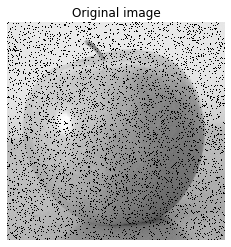

In [1]:
# This makes plots appear in the notebook
%matplotlib inline 

import numpy as np # numpy is the major library in which siamxt was built upon
                   # we like the array programming style =)

# We are using PIL to read images     
from PIL import Image

# and matplotlib to display images
import matplotlib.pyplot as plt

import time # Let's measure some processing times

import siamxt  

# Loading the image.
# Make sure the image you read is either uint8 or uint16
img = np.asarray(Image.open("./Sample-images/apple.png"))
print("Image dimensions: %dx%d pixels" %img.shape)

#Displaying the image
fig = plt.figure()
plt.imshow(img, cmap='Greys_r')
plt.axis('off')
plt.title("Original image")


#Structuring element with connectivity-8
Bc = np.ones((3,3),dtype = bool)

t = time.time()
#Building the max-tree with the connectivity defined
mxt = siamxt.MaxTreeAlpha(img,Bc)
t = time.time() -t

print("Max-tree build time: %fs" %t)
print("Number of max-tree nodes: %d" %mxt.node_array.shape[1])
print("Number of max-tree leaves: %d" %(mxt.node_array[1,:] == 0).sum())

Area-open filter
-----------------

The image loaded is corrupted with pepper noise (black spots). The max-tree is maxima oriented (white regions). In order to filter the pepper noise, we need to work with the min-tree, which is equivalent to process the max-tree of the negated image. Line of the code negates the image. Line 9 builds the max-tree of the negated image (i.e. min-tree). Line 12 makes a hard copy of the max-tree structure. Line 15 applies the area-open filter, which consists in removing nodes with area smaller than a threshold. Line 18 recovers the image corresponding to the filtered max-tree. Line 21 negates the recovered image. We can see that the pepper noise was filtered from the image. Filtering a max-tree is a connected filter, i.e. a filte that does not blur the image.

Text(0.5, 1.0, 'area-open, area = 25 ')

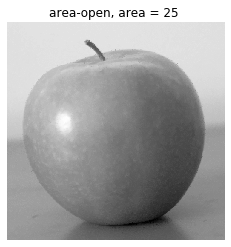

In [2]:
# Negating the image
img_max = img.max()
img_neg = img_max-img

# Area threshold
area = 25

#Building the max-tree of the negated image, i.e. min-tree
mxt_neg = siamxt.MaxTreeAlpha(img_neg,Bc)

# Making a hard copy of the max-tree
mxt_neg2 = mxt_neg.clone()

#Applying an area-open filter
mxt_neg.areaOpen(area)

#Recovering the image 
img_filtered =  mxt_neg.getImage()

# Negating the image back
img_filtered = img_max -img_filtered

#Displaying the filtered image
fig = plt.figure()
plt.imshow(img_filtered, cmap='Greys_r')
plt.axis('off')
plt.title("area-open, area = %d " %area)


Extinction filter
------------------

Extinction filters are extrema oriented filters. They preserve the **n** extrema (minima or maxima) with highest extinction values. It compared well against attribute filters, like area-open, in the following publication:

** R. Souza, L. Rittner, R. Machado, and R. Lotufo, “A comparison between extinction filters and attribute filters,” in ISMM’15, Reykjavik, Iceland, May 27-29, 2015. Proceedings, pp. 63–74, 2015.**

In this example, we preserved 5 minima (line 2) in the image. Line 5 extracts the area of the max-tree nodes from the NA structure. Line 8 computes the area extinction values. Line 11 applies the extinction filter. The remaining of the code is similar to the previous area-open example. The filtered image is displayed below.



Text(0.5, 1.0, 'area extinction filter, n= 5 ')

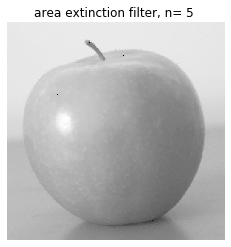

In [3]:
# Number of leaves to be preserved
n = 5

# Select the area attribute of the max-tree nodes from NA
area = mxt_neg2.node_array[3,:]

# Computes the area extinction values
area_ext = mxt_neg2.computeExtinctionValues(area,"area")

# Applies the  area extinction filter
mxt_neg2.extinctionFilter(area_ext,n)

#Recovering the image 
img_filtered2 =  mxt_neg2.getImage()

# Negating the image back
img_filtered2 = img_max -img_filtered2

#Displaying the filtered image
fig = plt.figure()
plt.imshow(img_filtered2, cmap='Greys_r')
plt.axis('off')
plt.title("area extinction filter, n= %d " %n)

Bounding-box filter
-----------------------

Different features can be extracted from the max-tree nodes. In this example, we use the boundig-box information that siamxt computed when building the max-tree to filter a license plate image the maximum we can without losing the license plate characters. Lines 16 through 20 define parameters of the filter, wich are the minimum and maximum bounding-box lengths and the minimum rectangularity ratio (rr) defined by:

\begin{equation*}
rr = \frac{area_{node}}{H_{bbox}W_{bbox}}
\end{equation*}

where $area_{node}$, $H_{bbox}$, $W_{bbox}$ are the area of the node and the height and width of the node's connected component bounding-box. The characters are dark, so we have to work with the negative of the image (lines 6 and 7). Lines 16 through 20 set the parameters of the filter. These parameters were set empirically. Lines 23 through 25 define a structuring element with connectivity-4.  Line 28 builds the min-tree. Lines 31 and 32 compute the bounding-box height (dx) and width (dy) for each max-tree node. The information of the nodes' bounding-box minimum and maximum coordiantes is computed during the max-tree construction, so computing the height and width comes straightfoward. Line 35 computes the nodes' rectangularity ratios.  Line 38 creates a boolean array with the max-tree nodes that attend the filtering criteria set to **True**. Line 41 performs the filtering using the max-tree direct filtering rule. The remianing of the code is similar to previous examples.

Image dimensions: 240x640 pixels


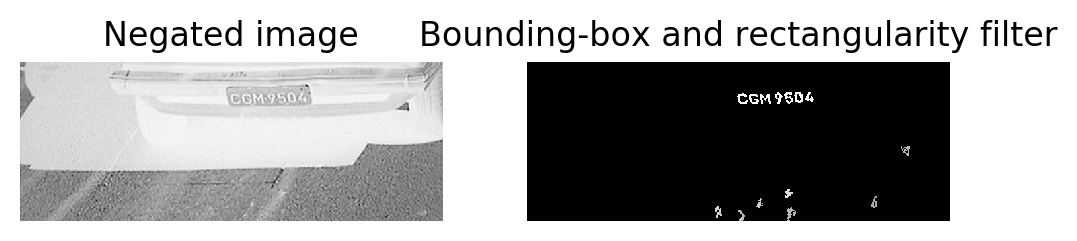

In [6]:
# Loading license plate image
img = np.asarray(Image.open("./Sample-images/plate.png"))
print("Image dimensions: %dx%d pixels" %img.shape)

# Negating the image
img_max = img.max()
img_neg = img.max() - img

#Displaying the image
fig = plt.figure(dpi = 200)
plt.subplot(121)
plt.imshow(img_neg, cmap='Greys_r')
plt.axis('off')
plt.title("Negated image")

# Filter parameters
Wmin = 7  # Minimum bounding-box width
Hmin = 13 # Minimum bounding-box height
Wmax = 17 # Maximum bounding-box width
Hmax = 25 # Maximum bounding-box height
rr = 0.45 # Minimum rectangularity ratio

#Structuring element with connectivity-4 
Bc = np.zeros((3,3), dtype = bool)
Bc[1,:] = True
Bc[:,1] = True

# Building the max-tree of the negated image, i.e. min-tree
mxt = siamxt.MaxTreeAlpha(img_neg,Bc)

# Bounding box-lengths
dx = mxt.node_array[7,:] - mxt.node_array[6,:]
dy = mxt.node_array[10,:] - mxt.node_array[9,:]

# Rectangularity ratio
RR = mxt.computeRR()

# Node selection criteria
nodes = (dx>Hmin) & (dx<Hmax) & (dy > Wmin) & (dy < Wmax) & (RR > rr)

#Filtering the max-tree
mxt.contractDR(nodes)

# Recovering the filtered the image
img_filtered = mxt.getImage()

 
#Displaying the filtered image
plt.subplot(122)
plt.imshow(img_filtered, cmap='Greys_r')
plt.axis('off')
plt.title("Bounding-box and rectangularity filter")
plt.show()

Max-tree area signature analysis
------------------------------------
One  important  concept  related  to  the  max-tree  is  the  attribute signature proposed in: 

**R. Jones, “Connected filtering and segmentation using component trees,” Computer Vision and
Image Understanding, vol. 75, no. 3, pp. 215–228, 1999.**

The max-tree signature consists  in  analyzing  an  attribute  variation  starting  at  a  leaf
node  and  going  towards  the  root. Signature analysis is a powerful tool to inspect how the
connected components evolve when you go through many threshold values. For instance, when there is a
sudden  change  in  the  area  signature  value,  it  may  represent a  connected  component  that
split  in  two  or  more  significant connected  components.  

In this example, we load a brain MR slice (line 2). A hand-picked pixel corresponding to a regional maximum is selected in line 16 and its corresponding node line 19. The area signature is computed in line 25 and the gradient of the area signature in line 28. The area signature and gradient plots are displayed. Peaks in the gradient represent a CC that split in two or more components. The largest peak in the gradient corresponds to the separation between the background and forground of the image. The second peak corresponds to the threshold where the brain and the skull split. Line 49 selects the second largest peak. Lines 51 through 54 and 56 through 59 reconstruct the nodes that correspond to the gradient peak.

Image dimensions: 256x256 pixels


Text(0.5, 1.0, 'Reconstruction at h = 32')

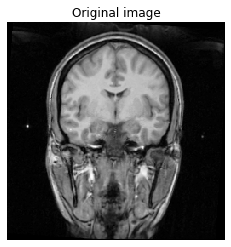

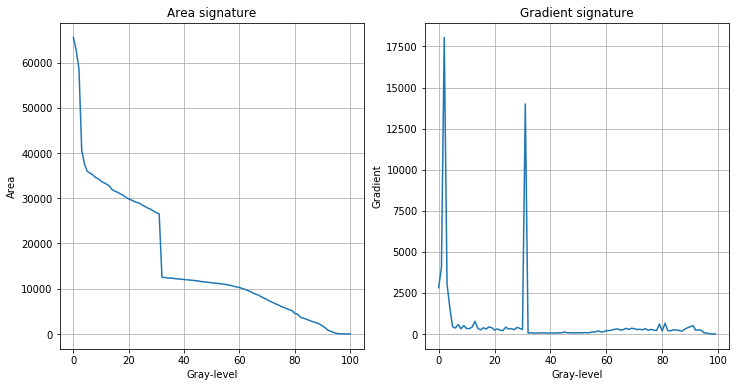

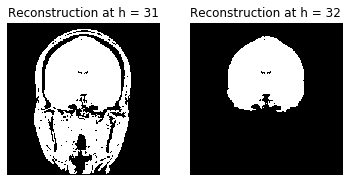

In [7]:
# Loading brain MR image
img = np.asarray(Image.open("./Sample-images/brain_coronal.png"))
print("Image dimensions: %dx%d pixels" %img.shape)


#Displaying the original image
fig = plt.figure()
plt.imshow(img, cmap='Greys_r')
plt.axis('off')
plt.title("Original image")

# Building the max-tree
mxt = siamxt.MaxTreeAlpha(img,Bc)

#Hand-picked regional maxima
x,y = 83,90

# Node corresponding to a regional maximum
node = mxt.node_index[x,y]

# Extracting area attribute from NA
area = mxt.node_array[3,:]

# Area signature computation
levels,signature =  mxt.getSignature(area, node)

#Gradient of the area signature
gradient = signature[0:-1] - signature[1:]

# Display area signature
fig = plt.figure(figsize = (12,6))
plt.subplot(121)
plt.plot(levels,signature)
plt.grid()
plt.xlabel("Gray-level")
plt.ylabel("Area")
plt.title("Area signature")


# Display gradient of the area signature
plt.subplot(122)
plt.grid()
plt.plot(levels[0:-1],gradient)
plt.xlabel("Gray-level")
plt.ylabel("Gradient")
plt.title("Gradient signature")


# Selecting the second peak of the gradient
index = np.argsort(gradient)[::-1][1]

#reconstructing the node corresponding to the peak (largest area)
area1 = signature[index]
node1 = np.where(mxt.node_array[3,:] == area1)[0][0]
cc1 = mxt.recConnectedComponent(node1)

#reconstructing the node corresponding to the peak (smaller area)
area2 = signature[index + 1]
node2 = np.where(mxt.node_array[3,:] == area2)[0][0]
cc2 = mxt.recConnectedComponent(node2)


#Displaying the nodes reconstructed    
fig = plt.figure()
plt.subplot(121)
plt.imshow(cc1, cmap='Greys_r')
plt.axis('off')
plt.title("Reconstruction at h = %d" %mxt.node_array[2,node1])
plt.subplot(122)
plt.imshow(cc2, cmap='Greys_r')
plt.axis('off')
plt.title("Reconstruction at h = %d" %mxt.node_array[2,node2])